In [19]:
import pandas as pd
import numpy as np
import seaborn as snb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
import string
from collections import Counter
from textblob import TextBlob
import gc
import re
import os
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
import warnings
import time
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import Lasso
from scipy.stats import spearmanr
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor, early_stopping, plot_importance
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from joblib import dump, load
warnings.filterwarnings('ignore')

In [2]:
stop_words = set(stopwords.words('english'))

In [3]:
'''Load dataset'''
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
target_cols = ['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']

### Text Preprocessing

In [5]:
'''Some initializations which will help in text preprocessing'''
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"its":"it is",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

rules = {
    "'t": " not",
    "'cause": " because",
    "'ve": " have",
    "'t": " not",
    "'s": " is",
    "'d": " had"
}

punctuations = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", 
                '$', '&', '/', '[', ']','>', '%', '=', '#', '*', '+', '\\', '•', '~', 
                '@', '£', '·', '_', '{', '}', '©', '^','®', '`', '<', '→', '°', '€', '™', 
                '›', '♥', '←', '×', '§', '″', '′', 'Â', '█','½', 'à', '…', '“', '★', '”', 
                '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶','↑', '±', '¿', '▾', '═', 
                '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼','⊕', '▼', '▪', '†',
                '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲','è', '¸', '¾', 
                'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪','╩', 
                '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 
                'ï', 'Ø', '¹', '≤', '‡', '√'] + list(string.punctuation)
punctuations_in_embeddings = {',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', 
                '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '{', '}', '©', '^', '®', 
                '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
                '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '═', 
                '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', 
                '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
                '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔',
                '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '!', '"', '#', '$', '%', '&', "'", '(', ')', 
                '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '{', 
                '|', '}', '~'}
token_replace = {
    'usepackage':'latex',
    'orf19':'gene',
    'documentclass':'latex',
    'magento':'open-source e-commerce',
    'appium':'web-app',
    'tikz':'programming language',
    'tikzpicture':'programming language',
    'openvpn':'vpn',
    'httpclient':'http client',
    'arraylist':'array list',
    'jsonobject': 'json',
    'artifactid':'xml',
    'hwnd':'os'
}

In [6]:
'''Pipeline for text preprocessing. Check coverage computes what %age of tokens in the text data 
are covered by Embeddings.
preprocess_text is used to clean text.
'''
def improve_text(dframes):
    def build_vocab(texts):
        vocab = {}
        for text in texts:
            for word in text.split():
                try:
                    vocab[word] += 1
                except:
                    vocab[word] = 1
        return vocab
    def preprocess_text(s):
        s = s.lower()
        '''Expanding contractions...'''
        for key, value in contractions.items():
            s = s.replace(key, f' {value} ')
        for key, value in rules.items():
            s = s.replace(key, f' {value} ')
        '''Fixing punctuations...'''
        for punct in punctuations:
            if punct in punctuations_in_embeddings:
                s = s.replace(punct, f' {punct} ')
            else:
                s = s.replace(punct, ' ')
        '''Replacing few tokens with its similar word/group of words...'''
        for key, value in token_replace.items():
            s = s.replace(key, value)
        '''Removing HTML tags'''
        s = re.sub('<.*?>', ' ', s)
        s = re.sub('\s+', ' ', s)
        return s
    
    def get_texts(c1 = 'question_title', c2='question_body', c3='answer'):
        all_texts = []
        for each_df in dframes:
            all_texts += each_df[c1].tolist() + each_df[c2].tolist() + \
            each_df[c3].tolist()
        return all_texts
    all_texts = get_texts()
    vocab = Counter(build_vocab(all_texts))
    print("Applying Preprocessing.....")
    for each_df in dframes:
        each_df['clean_title'] = each_df['question_title'].apply(preprocess_text)
        each_df['clean_question_body'] = each_df['question_body'].apply(preprocess_text)
        each_df['clean_answer'] = each_df['answer'].apply(preprocess_text)
    print("Preprocessing Finished")

In [7]:
improve_text([train_df, test_df])

Applying Preprocessing.....
Preprocessing Finished


#### Handcrafted Features

In [8]:
'''Compute the polarity of text data'''
def get_polarity(s):
    return TextBlob(s).sentiment.polarity

train_df['question_title_polarity'] = train_df.clean_title.apply(get_polarity)
train_df['question_body_polarity'] = train_df.clean_question_body.apply(get_polarity)
train_df['answer_polarity'] = train_df.clean_answer.apply(get_polarity)
test_df['question_title_polarity'] = test_df.clean_title.apply(get_polarity)
test_df['question_body_polarity'] = test_df.clean_question_body.apply(get_polarity)
test_df['answer_polarity'] = test_df.clean_answer.apply(get_polarity)
##################################################################################################################
train_df['question_title_count'] = train_df.clean_title.apply(lambda x: len(x.split()))
train_df['question_body_count'] = train_df.clean_question_body.apply(lambda x: len(x.split()))
train_df['answer_count'] = train_df.clean_answer.apply(lambda x: len(x.split()))
test_df['question_title_count'] = test_df.clean_title.apply(lambda x: len(x.split()))
test_df['question_body_count'] = test_df.clean_question_body.apply(lambda x: len(x.split()))
test_df['answer_count'] = test_df.clean_answer.apply(lambda x: len(x.split()))

* **Token** - Components of a text which you obtain by splitting up text on spaces.
* **Stopwords** - A stopword is a commonly used word such as ‘a’, ‘an’, ‘the’ etc. Such words are typically removed from the text during preprocessing.
* **Word** - A token which is not a stopword.
    * We can use these definitions to handcraft features. Given a pair of text T1 and T2, 
        * cwc_min = ratio of common_word_count to min(# of T1 words, # of T2 words )* 
        * cwc_max = ratio of common_word_count to max(# of T1 words, # of T2 words)
        * csc_min = ratio of common_stopwords_count to min(# of T1 stopwords, # of T2 stopwords )
        * csc_max = ratio of common_stopwords_count to max(# of T1 stopwords, # of T2 stopwords )
        * ctc_min = ratio of common_token_count to min(# of tokens in T1, # of tokens in T2)
        * ctc_max = ratio of common_token_count to max(# of tokens in T1, # of tokens in T2)
        * word_t1_to_t2_ratio = (# of words in T1) / (# of words in T2) 
        * token_t1_to_t2_ratio = (# of tokens in T1) / (# of tokens in T2)
        * last_word_eq = boolean( T1[-1] == T2[-1] )
        * first_word_eq = boolean( T1[0] == T2[0] )
* **Fuzzywuzzy** - https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    * These features take a pair of text as input and returns the score out of 100 as an output. Internally this library uses SequenceMatcher class to compute %age similarity between pairs of texts. Implementation details are provided in the above link.
    * **Fuzz ratio** - It simply uses SequenceMatcher to compute similarity between pairs of text. The SequenceMatcher outputs the similarity between 0 to 1. This fuzz ratio converts decimals to percentage i.e. 0 to 100. 
    * **Partial Fuzz Ratio** - If the pair of text have different lengths, i.e. smaller string of length m, larger string of length n, this feature computes ratio based on the best m-length substring. 
    * **Token Ratio** - In this approach, each text is tokenized and these tokens are sorted based on alphabetical order. The SequenceMatcher is then used to compute ratios. 
    * **Token Set Ratio** - The approach is as follows 
      * S1 - Create a set of intersection of tokens between T1 and T2.
      * S2 - S1 + Create a set of tokens present in T1 but not in T2
      * S3 - S1 + Create a set of tokens present in T2 but not in T1.
      * return  max ( score( S1, S2 ), score( S1, S3 ), score( S2, S3 )). Scores are computed using SequenceMatcher.



In [12]:
def fetch_words(s, use_stopwords = False, ignore_stopwords = False):
    if ignore_stopwords == True:
        return {word for word in s.split() if word not in stop_words}
    elif use_stopwords:
        return {word for word in s.split() if word in stop_words}
    else:
        return set(s.split())
def text_features(row, uss_stopwords, is_token, return_max):
    t1, t2 = None, None
    if uss_stopwords == True:
        t1 = fetch_words(row[0], use_stopwords = True)
        t2 = fetch_words(row[1], use_stopwords = True)
    elif is_token == True:
        t1 = fetch_words(row[0], ignore_stopwords = True)
        t2 = fetch_words(row[1], ignore_stopwords = True)
    else:
        t1 = fetch_words(row[0])
        t2 = fetch_words(row[1])
    if return_max:
        try:
            ans = len(t1.intersection(t2))/max(len(t1), len(t2))
        except:
            return 0
    else:
        try:
            ans = len(t1.intersection(t2))/min(len(t1), len(t2))
        except:
            return 0
    return ans

def get_ratio(row, is_token = False):
    if is_token == True:
        t1 = len(set([word for word in row[0].split() if word not in stop_words]))
        t2 = len(set([word for word in row[1].split() if word not in stop_words]))
    t1 = len(set([word for word in row[0].split()]))
    t2 = len(set([word for word in row[1].split()]))
    try:
        return t1/t2
    except:
        return 0
def get_fuzzy_ratio(row, ratio, partial_ratio, token_sort_ratio, token_set_ratio):
    if ratio:
        return fuzz.ratio(row[0], row[1])/100
    elif partial_ratio:
        return fuzz.partial_ratio(row[0], row[1])/100
    elif token_sort_ratio:
        return fuzz.token_sort_ratio(row[0], row[1])/100
    else:
        return fuzz.token_set_ratio(row[0], row[1])/100

In [10]:
feature_engg_cols = ['cwc_min_title_question_body',
       'cwc_max_title_question_body', 'csc_min_title_question_body',
       'csc_max_title_question_body', 'ctc_min_title_question_body',
       'ctc_max_title_question_body', 'cwc_min_title_answer',
       'cwc_max_title_answer', 'csc_min_title_answer', 'csc_max_title_answer',
       'ctc_min_title_answer', 'ctc_max_title_answer',
       'cwc_min_question_body_answer', 'cwc_max_question_body_answer',
       'csc_min_question_body_answer', 'csc_max_question_body_answer',
       'ctc_min_question_body_answer', 'ctc_max_question_body_answer',
       'word_title_question_body_ratio', 'token_title_question_body_ratio',
       'word_question_body_answer_ratio', 'token_question_body_answer_ratio',
       'word_title_answer_ratio', 'token_title_answer_ratio',
       'ratio_title_question_body', 'partial_ratio_title_question_body',
       'token_sort_ratio_title_question_body',
       'token_set_ratio_title_question_body', 'ratio_question_body_answer',
       'partial_ratio_question_body_answer',
       'token_sort_ratio_question_body_answer',
       'token_set_ratio_question_body_answer', 'ratio_title_answer',
       'partial_ratio_title_answer', 'token_sort_ratio_title_answer',
       'token_set_ratio_title_answer']

In [13]:
##################################        TRAIN        ############################################################

train_df['cwc_min_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
train_df['cwc_max_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
train_df['csc_min_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
train_df['csc_max_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
train_df['ctc_min_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
train_df['ctc_max_title_question_body'] = train_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))
train_df['cwc_min_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
train_df['cwc_max_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
train_df['csc_min_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
train_df['csc_max_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
train_df['ctc_min_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
train_df['ctc_max_title_answer'] = train_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))
train_df['cwc_min_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
train_df['cwc_max_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
train_df['csc_min_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
train_df['csc_max_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
train_df['ctc_min_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
train_df['ctc_max_question_body_answer'] = train_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))

train_df['word_title_question_body_ratio'] = train_df[['clean_title', 'clean_question_body']].apply(
    func = get_ratio, axis = 1, args = (False, ))
train_df['token_title_question_body_ratio'] = train_df[['clean_title', 'clean_question_body']].apply(
    func = get_ratio, axis = 1, args = (True, ))
train_df['word_question_body_answer_ratio'] = train_df[['clean_question_body', 'clean_answer']].apply(
    func = get_ratio, axis = 1, args = (False, ))
train_df['token_question_body_answer_ratio'] = train_df[['clean_question_body', 'clean_answer']].apply(
    func = get_ratio, axis = 1, args = (True, ))
train_df['word_title_answer_ratio'] = train_df[['clean_title', 'clean_answer']].apply(func = get_ratio, 
                                                axis = 1, args = (False, ))
train_df['token_title_answer_ratio'] = train_df[['clean_title', 'clean_answer']].apply(func = get_ratio, 
                                                axis = 1, args = (True, ))

train_df['ratio_title_question_body'] = \
train_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False))
train_df['partial_ratio_title_question_body'] = \
train_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
train_df['token_sort_ratio_title_question_body'] = \
train_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
train_df['token_set_ratio_title_question_body'] = \
train_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))
train_df['ratio_question_body_answer'] = \
train_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False ))
train_df['partial_ratio_question_body_answer'] = \
train_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
train_df['token_sort_ratio_question_body_answer'] = \
train_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
train_df['token_set_ratio_question_body_answer'] = \
train_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))
train_df['ratio_title_answer'] = \
train_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False))
train_df['partial_ratio_title_answer'] = \
train_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
train_df['token_sort_ratio_title_answer'] = \
train_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
train_df['token_set_ratio_title_answer'] = \
train_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))

##################################        TEST        ############################################################

test_df['cwc_min_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
test_df['cwc_max_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
test_df['csc_min_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
test_df['csc_max_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
test_df['ctc_min_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
test_df['ctc_max_title_question_body'] = test_df[['clean_title', 'clean_question_body']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))
test_df['cwc_min_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
test_df['cwc_max_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
test_df['csc_min_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
test_df['csc_max_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
test_df['ctc_min_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
test_df['ctc_max_title_answer'] = test_df[['clean_title', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))
test_df['cwc_min_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, False))
test_df['cwc_max_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, False, True))
test_df['csc_min_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, False))
test_df['csc_max_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (True, False, True))
test_df['ctc_min_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, False))
test_df['ctc_max_question_body_answer'] = test_df[['clean_question_body', 'clean_answer']].apply(func = text_features, 
                                                axis = 1, args = (False, True, True))

test_df['word_title_question_body_ratio'] = test_df[['clean_title', 'clean_question_body']].apply(
    func = get_ratio, axis = 1, args = (False, ))
test_df['token_title_question_body_ratio'] = test_df[['clean_title', 'clean_question_body']].apply(
    func = get_ratio, axis = 1, args = (True, ))
test_df['word_question_body_answer_ratio'] = test_df[['clean_question_body', 'clean_answer']].apply(
    func = get_ratio, axis = 1, args = (False, ))
test_df['token_question_body_answer_ratio'] = test_df[['clean_question_body', 'clean_answer']].apply(
    func = get_ratio, axis = 1, args = (True, ))
test_df['word_title_answer_ratio'] = test_df[['clean_title', 'clean_answer']].apply(func = get_ratio, 
                                                axis = 1, args = (False, ))
test_df['token_title_answer_ratio'] = test_df[['clean_title', 'clean_answer']].apply(func = get_ratio, 
                                                axis = 1, args = (True, ))

test_df['ratio_title_question_body'] = \
test_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False))
test_df['partial_ratio_title_question_body'] = \
test_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
test_df['token_sort_ratio_title_question_body'] = \
test_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
test_df['token_set_ratio_title_question_body'] = \
test_df[['clean_title', 'clean_question_body']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))
test_df['ratio_question_body_answer'] = \
test_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False ))
test_df['partial_ratio_question_body_answer'] = \
test_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
test_df['token_sort_ratio_question_body_answer'] = \
test_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
test_df['token_set_ratio_question_body_answer'] = \
test_df[['clean_question_body', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))
test_df['ratio_title_answer'] = \
test_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (True, False, False, False))
test_df['partial_ratio_title_answer'] = \
test_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, True, False, False))
test_df['token_sort_ratio_title_answer'] = \
test_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, True, False))
test_df['token_set_ratio_title_answer'] = \
test_df[['clean_title', 'clean_answer']].apply(func = get_fuzzy_ratio, 
                                                 axis = 1, args = (False, False, False, True))

#### Bag-of-Words & TfIDF

In [14]:
def tokenize_sklearn(text, use_stopwords):
    if use_stopwords:
        return [word for word in text.split()]
    else:
        return [word for word in text.split() if word not in stop_words]
    

In [15]:
train_df['question'] = train_df['clean_title'] + ' ' + train_df['clean_question_body']
test_df['question'] = test_df['clean_title'] + ' ' + test_df['clean_question_body']

In [16]:
'''Feature Extraction using BoW and TfIDF '''
data = {}
def get_text_features_sklearn_based(train_text, test_text, name, get_tfidf, use_stopwords):
    if get_tfidf == True:
        vec = TfidfVectorizer(tokenizer = lambda x:tokenize_sklearn(x, use_stopwords))
    else:
        vec = CountVectorizer(tokenizer = lambda x:tokenize_sklearn(x, use_stopwords))
    vec.fit(train_text)
    arr = vec.transform(test_text)
    data[name] = arr
get_text_features_sklearn_based(train_df['clean_title'], train_df['clean_title'], 'train_title_bow_s', False, 
                                True)
get_text_features_sklearn_based(train_df['clean_question_body'], train_df['clean_question_body'], 
                                'train_question_body_bow_s', False, True)
get_text_features_sklearn_based(train_df['clean_answer'], train_df['clean_answer'], 'train_answer_bow_s', False,
                               True)

get_text_features_sklearn_based(train_df['clean_title'], test_df['clean_title'], 'test_title_bow_s', False,
                               True)
get_text_features_sklearn_based(train_df['clean_question_body'], test_df['clean_question_body'], 
                                'test_question_body_bow_s', False, True)
get_text_features_sklearn_based(train_df['clean_answer'], test_df['clean_answer'], 'test_answer_bow_s', False,
                               True)

get_text_features_sklearn_based(train_df['clean_title'], train_df['clean_title'], 'train_title_tfidf_s', True,
                               True)
get_text_features_sklearn_based(train_df['clean_question_body'], train_df['clean_question_body'], 
                                'train_question_body_tfidf_s', True, True)
get_text_features_sklearn_based(train_df['clean_answer'], train_df['clean_answer'], 'train_answer_tfidf_s', True,
                               True)

get_text_features_sklearn_based(train_df['clean_title'], test_df['clean_title'], 'test_title_tfidf_s', True,
                               True)
get_text_features_sklearn_based(train_df['clean_question_body'], test_df['clean_question_body'], 
                                'test_question_body_tfidf_s', True, True)
get_text_features_sklearn_based(train_df['clean_answer'], test_df['clean_answer'], 'test_answer_tfidf_s', True,
                               True)


get_text_features_sklearn_based(train_df['clean_title'], train_df['clean_title'], 'train_title_bow_ns', False,
                               False)
get_text_features_sklearn_based(train_df['clean_question_body'], train_df['clean_question_body'], 
                                'train_question_body_bow_ns', False, False)
get_text_features_sklearn_based(train_df['clean_answer'], train_df['clean_answer'], 'train_answer_bow_ns', False,
                               False)

get_text_features_sklearn_based(train_df['clean_title'], test_df['clean_title'], 'test_title_bow_ns', False, 
                               False)
get_text_features_sklearn_based(train_df['clean_question_body'], test_df['clean_question_body'], 
                                'test_question_body_bow_ns', False, False)
get_text_features_sklearn_based(train_df['clean_answer'], test_df['clean_answer'], 'test_answer_bow_ns', False,
                               False)

get_text_features_sklearn_based(train_df['clean_title'], train_df['clean_title'], 'train_title_tfidf_ns', True,
                               False)
get_text_features_sklearn_based(train_df['clean_question_body'], train_df['clean_question_body'], 
                                'train_question_body_tfidf_ns', True, False)
get_text_features_sklearn_based(train_df['clean_answer'], train_df['clean_answer'], 'train_answer_tfidf_ns', True,
                               False)

get_text_features_sklearn_based(train_df['clean_title'], test_df['clean_title'], 'test_title_tfidf_ns', True, 
                               False)
get_text_features_sklearn_based(train_df['clean_question_body'], test_df['clean_question_body'], 
                                'test_question_body_tfidf_ns', True, False)
get_text_features_sklearn_based(train_df['clean_answer'], test_df['clean_answer'], 'test_answer_tfidf_ns', True, 
                               False)

In [17]:
get_text_features_sklearn_based(train_df['question'], train_df['question'], 'train_question_tfidf_s', True, 
                               True)
get_text_features_sklearn_based(train_df['question'], train_df['question'], 'train_question_tfidf_ns', True, 
                               False)
get_text_features_sklearn_based(train_df['question'], test_df['question'], 'test_question_tfidf_s', True, 
                               True)
get_text_features_sklearn_based(train_df['question'], test_df['question'], 'test_question_tfidf_ns', True, 
                               False)

get_text_features_sklearn_based(train_df['question'], train_df['question'], 'train_question_bow_s', False, 
                               True)
get_text_features_sklearn_based(train_df['question'], train_df['question'], 'train_question_bow_ns', False, 
                               False)
get_text_features_sklearn_based(train_df['question'], test_df['question'], 'test_question_bow_s', False, 
                               True)
get_text_features_sklearn_based(train_df['question'], test_df['question'], 'test_question_bow_ns', False, 
                               False)

#### Feature Extraction using Word2Vec

In [21]:
'''Initializing Word2Vec model and Finetuning'''

train_df['combine_text'] = train_df.clean_title + ' ' + train_df.clean_question_body + ' ' + train_df.clean_answer
test_df['combine_text'] = test_df.clean_title + test_df.clean_question_body + test_df.clean_answer
all_texts = train_df['combine_text'].tolist()
all_texts = [text.split() for text in all_texts]
model = Word2Vec(size = 300, min_count = 1, window = 5)
model.build_vocab(all_texts)
model.intersect_word2vec_format('fasttext-wiki-news-subwords-300.gz', lockf = 1)
model.train(all_texts, total_examples = model.corpus_count, epochs = 5)



(8564109, 12226825)

In [22]:
w2v_word_to_index = {word:index for index, word in enumerate(model.wv.index2word)}
w2v_index_to_word = {index:word for index, word in enumerate(model.wv.index2word)}

In [23]:
def baseline_w2v_embeddings(texts, matrix, is_tfidf, use_stopwords):
    feature_ids = []
    if is_tfidf == True:
        vec = TfidfVectorizer(tokenizer = lambda x: tokenize_sklearn(x, use_stopwords))
        vec.fit(texts)
        embedding_matrix = np.zeros((len(vec.get_feature_names()), 300))
        for index, each_word in enumerate(vec.get_feature_names()):
            embedding_matrix[index] = model.wv[each_word]
        ans = np.zeros((matrix.shape[0], 300))
        for i in range(matrix.shape[0]):
            helper_array = np.dot(matrix[i:i+1].A, embedding_matrix)
            ans[i] = helper_array
        return ans
    else:
        vec = CountVectorizer(tokenizer = lambda x: tokenize_sklearn(x, use_stopwords))
        vec.fit(texts)
        embedding_matrix = np.zeros((len(vec.get_feature_names()), 300))
        for index, each_word in enumerate(vec.get_feature_names()):
            embedding_matrix[index] = model.wv[each_word]
        
        ans = np.zeros((matrix.shape[0], 300))
        norm_matrix = matrix/matrix.sum(axis = 1)
        for i in range(matrix.shape[0]):
            helper_array = np.dot(norm_matrix[i:i+1], embedding_matrix)
            ans[i] = helper_array
        return ans

In [24]:
t0 = time.time()
data['train_title_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_title, data['train_title_bow_s'], False, True)
data['train_question_body_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_question_body, data['train_question_body_bow_s'], False, True)
data['train_answer_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_answer, data['train_answer_bow_s'], False, True)

data['test_title_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_title, data['test_title_bow_s'], False, True)
data['test_question_body_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_question_body, data['test_question_body_bow_s'], False, True)
data['test_answer_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_answer, data['test_answer_bow_s'], False, True)

data['train_title_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_title, data['train_title_tfidf_s'], True, True)
data['train_question_body_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_question_body, data['train_question_body_tfidf_s'], True, True)
data['train_answer_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_answer, data['train_answer_tfidf_s'], True, True)

data['test_title_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_title, data['test_title_tfidf_s'], True, True)
data['test_question_body_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_question_body, data['test_question_body_tfidf_s'], True, True)
data['test_answer_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.clean_answer, data['test_answer_tfidf_s'], True, True)

data['train_title_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_title, data['train_title_bow_ns'], False, False)
data['train_question_body_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_question_body, data['train_question_body_bow_ns'], False, False)
data['train_answer_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_answer, data['train_answer_bow_ns'], False, False)

data['test_title_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_title, data['test_title_bow_ns'], False, False)
data['test_question_body_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_question_body, data['test_question_body_bow_ns'], False, False)
data['test_answer_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_answer, data['test_answer_bow_ns'], False, False)

data['train_title_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_title, data['train_title_tfidf_ns'], True, False)
data['train_question_body_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_question_body, data['train_question_body_tfidf_ns'], True, False)
data['train_answer_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_answer, data['train_answer_tfidf_ns'], True, False)

data['test_title_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_title, data['test_title_tfidf_ns'], True, False)
data['test_question_body_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_question_body, data['test_question_body_tfidf_ns'], True, False)
data['test_answer_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.clean_answer, data['test_answer_tfidf_ns'], True, False)

####################################################################################
data['train_question_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.question, data['train_question_tfidf_ns'], True, False)
data['train_question_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.question, data['train_question_tfidf_ns'], True, False)


data['test_question_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.question, data['test_question_tfidf_ns'], True, False)
data['test_question_tfidf_w2v_ns'] = \
baseline_w2v_embeddings(train_df.question, data['test_question_tfidf_ns'], True, False)


data['train_question_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.question, data['train_question_tfidf_s'], True, True)
data['train_question_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.question, data['train_question_tfidf_s'], True, True)


data['test_question_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.question, data['test_question_tfidf_s'], True, True)
data['test_question_tfidf_w2v_s'] = \
baseline_w2v_embeddings(train_df.question, data['test_question_tfidf_s'], True, True)

#####################################################################################

data['train_question_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.question, data['train_question_bow_ns'], False, False)
data['train_question_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.question, data['train_question_bow_ns'], False, False)


data['test_question_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.question, data['test_question_bow_ns'], False, False)
data['test_question_avg_w2v_ns'] = \
baseline_w2v_embeddings(train_df.question, data['test_question_bow_ns'], False, False)


data['train_question_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.question, data['train_question_bow_s'], False, True)
data['train_question_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.question, data['train_question_bow_s'], False, True)


data['test_question_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.question, data['test_question_bow_s'], False, True)
data['test_question_avg_w2v_s'] = \
baseline_w2v_embeddings(train_df.question, data['test_question_bow_s'], False, True)

print(f"Time taken : {np.round((time.time() - t0)/60, 3)} mins")

Time taken : 10.842 mins


### Cosine Similarity & l2 distance

In [25]:
def get_cosine_sim(a1, a2, name, data):
    numerator = np.multiply(a1, a2).sum(axis = 1)
    denominator = np.multiply(np.sqrt((a1**2).sum(axis = 1)), np.sqrt((a2**2).sum(axis = 1)))
    data[name] = (numerator/denominator).reshape((-1, 1))

def get_l2_dist(a1, a2, name, data):
    data[name] = np.sum((a1 - a2)**2, axis = 1).reshape((-1, 1))

In [27]:
file = np.load('ml_models/use-embeddings.npz', allow_pickle=True)
train_embeddings = file['a'].tolist()
test_embeddings = file['b'].tolist()

In [28]:
get_cosine_sim(train_embeddings['question_title'].numpy(), 
                train_embeddings['question_body'].numpy(), 'train_title_body_sim', data)

get_cosine_sim(train_embeddings['question_title'].numpy(), 
                train_embeddings['answer'].numpy(), 'train_title_answer_sim', data)

get_cosine_sim(train_embeddings['question_body'].numpy(), 
                train_embeddings['answer'].numpy(), 'train_body_answer_sim', data)

get_cosine_sim(test_embeddings['question_title'].numpy(), 
                test_embeddings['question_body'].numpy(), 'test_title_body_sim', data)

get_cosine_sim(test_embeddings['question_title'].numpy(), 
                test_embeddings['answer'].numpy(), 'test_title_answer_sim', data)

get_cosine_sim(test_embeddings['question_body'].numpy(), 
                test_embeddings['answer'].numpy(), 'test_body_answer_sim', data)
################################################################################################################

get_l2_dist(train_embeddings['question_title'].numpy(), 
                train_embeddings['question_body'].numpy(), 'train_title_body_l2', data)

get_l2_dist(train_embeddings['question_title'].numpy(), 
                train_embeddings['answer'].numpy(), 'train_title_answer_l2', data)

get_l2_dist(train_embeddings['question_body'].numpy(), 
                train_embeddings['answer'].numpy(), 'train_body_answer_l2', data)

get_l2_dist(test_embeddings['question_title'].numpy(), 
                test_embeddings['question_body'].numpy(), 'test_title_body_l2', data)

get_l2_dist(test_embeddings['question_title'].numpy(), 
                test_embeddings['answer'].numpy(), 'test_title_answer_l2', data)

get_l2_dist(test_embeddings['question_body'].numpy(), 
                test_embeddings['answer'].numpy(), 'test_body_answer_l2', data)

In [29]:
l2_cos_cols = ['train_title_body_sim',
'train_title_answer_sim',
'train_body_answer_sim',
'train_title_body_l2',
'train_title_answer_l2',
'train_body_answer_l2']

In [30]:
train_combined_l2_cos = np.hstack((data['train_title_body_sim'], data['train_title_answer_sim'], 
                                   data['train_body_answer_sim'], data['train_title_body_l2'],
                                   data['train_title_answer_l2'], data['train_body_answer_l2']))

### Meta Feature Engineering
* Additional Features as explained in - https://www.kaggle.com/c/google-quest-challenge/discussion/130041

In [31]:
meta_features = ['category_freq_encoding',
       'title_first_word_freq_encoding', 'title_last_word_freq_encoding',
       'question_first_word_freq_encoding', 'question_last_word_freq_encoding',
       'answer_first_word_freq_encoding', 'answer_last_word_freq_encoding', 'domain_freq_encoding',
        'title_count', 'question_body_count', 'answer_count']

In [32]:
def first_word(x):
    try:
        return x.split()[0]
    except:
        return ''
def last_word(x):
    try:
        return x.split()[-1]
    except:
        return ''

In [33]:
train_df['domain'] = train_df.host.apply(lambda s:s.split('.')[0])
test_df['domain'] = test_df.host.apply(lambda s:s.split('.')[0])

In [34]:
def get_freq_encoding(train_df, test_df, col_name):
    freq = train_df.groupby(col_name).size()/len(train_df)
    test_df[col_name+'_'+'freq_encoding'] = test_df[col_name].map(freq)
    test_df[col_name+'_'+'freq_encoding'] = test_df[col_name+'_'+'freq_encoding'].fillna(0)

train_df['title_first_word'] = train_df.clean_title.apply(first_word)
train_df['title_last_word'] = train_df.clean_title.apply(last_word)
train_df['question_first_word'] = train_df.clean_question_body.apply(first_word)
train_df['question_last_word'] = train_df.clean_question_body.apply(last_word)
train_df['answer_first_word'] = train_df.clean_answer.apply(first_word)
train_df['answer_last_word'] = train_df.clean_answer.apply(last_word)

test_df['title_first_word'] = test_df.clean_title.apply(first_word)
test_df['title_last_word'] = test_df.clean_title.apply(last_word)
test_df['question_first_word'] = test_df.clean_question_body.apply(first_word)
test_df['question_last_word'] = test_df.clean_question_body.apply(last_word)
test_df['answer_first_word'] = test_df.clean_answer.apply(first_word)
test_df['answer_last_word'] = test_df.clean_answer.apply(last_word)

get_freq_encoding(train_df, train_df, 'title_first_word')
get_freq_encoding(train_df, train_df, 'title_last_word')
get_freq_encoding(train_df, train_df, 'question_first_word')
get_freq_encoding(train_df, train_df, 'question_last_word')
get_freq_encoding(train_df, train_df, 'answer_first_word')
get_freq_encoding(train_df, train_df, 'answer_last_word')

get_freq_encoding(train_df, test_df, 'title_first_word')
get_freq_encoding(train_df, test_df, 'title_last_word')
get_freq_encoding(train_df, test_df, 'question_first_word')
get_freq_encoding(train_df, test_df, 'question_last_word')
get_freq_encoding(train_df, test_df, 'answer_first_word')
get_freq_encoding(train_df, test_df, 'answer_last_word')

get_freq_encoding(train_df, train_df, 'category')
get_freq_encoding(train_df, test_df, 'category')

get_freq_encoding(train_df, train_df, 'domain')
get_freq_encoding(train_df, test_df, 'domain')
train_df['title_count'] = train_df.clean_title.apply(lambda x:len(x.split()))
train_df['question_body_count'] = train_df.clean_question_body.apply(lambda x:len(x.split()))
train_df['answer_count'] = train_df.clean_answer.apply(lambda x:len(x.split()))

test_df['title_count'] = test_df.clean_title.apply(lambda x:len(x.split()))
test_df['question_body_count'] = test_df.clean_question_body.apply(lambda x:len(x.split()))
test_df['answer_count'] = test_df.clean_answer.apply(lambda x:len(x.split()))

In [35]:
def is_eng(x):
    if ((x == 'english') | (x == 'eli')):
        return 1
    return 0
train_df['is_eng'] = train_df.domain.apply(lambda x:is_eng(x))
def question_type(row):
    if ((row['is_eng'] == 1) & (row['a_count'] > 95)):
        return 1
    else:
        return 0
train_df['a_count'] = train_df.answer.apply(lambda x: len(x.split()))
train_df['question_type_spelling_modified'] = train_df[['is_eng', 'a_count']].apply(question_type, axis = 1)

### Model Construction

* Here, 4 regressors are used namely (LightGBM, Decision Tree, Lasso, Support Vector Regressor)
* In case of LightGBM and SVR, a target has a seperate model
* For Decision Tree and Lasso, a single model is trained over all the targets
* Features used in all the 4 models are :
    * (TfIDf Word2Vec with Stop Words for Question + TfIDf Word2Vec with Stop Words for Answer + l2 Similarity + Cosine Similarity + Meta Features + Fuzzywuzzy ratios)

In [36]:
def SpearmanCorrCoeff(A, B):
    overall_score = 0
    if len(A.shape) == 1:
        A = A[:, np.newaxis]
    if len(B.shape) == 1:
        B = B[:, np.newaxis]
    for index in range(A.shape[1]):
        overall_score += spearmanr(A[:, index], B[:, index]).correlation
    return overall_score/A.shape[1]
def create_model(name, X, Y):
    gkf = GroupKFold(n_splits = 5).split(X = train_df.url, groups = train_df.url)
    if name == 'lasso':
        alphas = [
            1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1
        ]
        max_iterations = [
            350, 750, 1000
        ]
        best_reg = None
        max_score = 0
        for fold, (train_idx, valid_idx) in enumerate(gkf):
            for alpha in alphas:
                for _iter in max_iterations:
                    params = {
                        'alpha':alpha,
                        'max_iter':_iter
                    }
                    reg = Lasso(**params)
                    reg.fit(X[train_idx], Y[train_idx])
                    y_pred = np.clip(reg.predict(X[valid_idx]), 0, 1)
                    y_pred[:, 19] = np.multiply(1, 
                                        train_df['question_type_spelling_modified'].values[valid_idx])
                    score = SpearmanCorrCoeff(y_pred, Y[valid_idx])
                    if score > max_score:
                        best_params = params
                        max_score = score
                        best_reg = reg
                    params['score'] = score
                    print(f"fold {fold} ----------> {params}")
                    
    elif name == 'decision_tree':
        criterions = ['mse', 'mae', 'friedman_mse']
        max_depths = [9, 11, 13, 15]
        min_samples_leaf = [60, 100, 170, 300]
        max_score = 0
        best_reg = None
        for fold, (train_idx, valid_idx) in enumerate(gkf):
            for depth in max_depths:
                for sample in min_samples_leaf:
                    params = {
                        'max_depth':depth,
                        'min_samples_leaf':sample
                    }
                    reg = DecisionTreeRegressor(**params)
                    reg.fit(X[train_idx], Y[train_idx])
                    y_pred = np.clip(reg.predict(X[valid_idx]), 0, 1)
                    score = SpearmanCorrCoeff(y_pred, Y[valid_idx])
                    if score > max_score:
                        max_score = score
                        best_reg = reg
                    params['score'] = score
                    print(f"fold {fold} ----------> {params}")
    return best_reg

In [37]:
class CustomSVR:
    def __init__(self, n_folds, urls):
        self.params = []
        self.get_parameters()
        self.scores = [0]*len(self.params)
        self.n_folds = 5
        self.urls = urls
        self.best_parameter = None
        self.reg = None
        self.val_score = []
    def get_parameters(self):
        C = [
            1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2
        ]
        max_iterations = [
            350, 750, 1000, -1
        ]
        for c in C:
            for _iter in max_iterations:
                self.params +=[{
                            'C':c,
                            'max_iter':_iter
                        }]
    def hyperparametertune(self, X, Y, target_index):
        for index, param in enumerate(self.params):
            max_score = 0
            print(param)
            gkf = GroupKFold(n_splits = self.n_folds).split(X = self.urls, groups = self.urls)
            score_lst = []
            for fold, (train_idx, valid_idx) in enumerate(gkf):
                reg = SVR(**param)
                X_train, Y_train, X_valid, Y_valid = (X[train_idx], Y[train_idx, target_index], 
                                             X[valid_idx], Y[valid_idx, target_index])
                reg.fit(X_train, Y_train)
                Y_pred = reg.predict(X_valid)
                score_lst += [SpearmanCorrCoeff(Y_pred, Y_valid)]
                print(f"fold - {fold}, target-index - {target_index}, score - {score_lst[-1]}")
            self.scores[index] = sum(score_lst)/5
        self.best_parameter = self.params[np.argmax(self.scores)]
    
    def fit_model(self, X, Y, use_fold):
        gkf = GroupKFold(n_splits = self.n_folds).split(X = self.urls, groups = self.urls)
        for fold, (train_idx, valid_idx) in enumerate(gkf):
            if fold == use_fold:
                self.reg = SVR(**self.best_parameter)
                self.reg.fit(X[train_idx], Y[train_idx])
    def validate_model(self, X, Y, use_fold):
        gkf = GroupKFold(n_splits = self.n_folds).split(X = self.urls, groups = self.urls)
        for fold, (train_idx, valid_idx) in enumerate(gkf):
            if fold == use_fold:
                y_pred = self.reg.predict(X[valid_idx])
                return SpearmanCorrCoeff(y_pred, Y[valid_idx])

In [38]:
class CustomLGB:
    def __init__(self, n_folds, urls):
        self.params = []
        self.get_parameters()
        self.scores = [0]*len(self.params)
        self.n_folds = 5
        self.urls = urls
        self.best_parameter = None
        self.reg = None
        self.val_score = []
    def get_parameters(self):
        max_depth = [7, 9]
        learning_rate = [0.07, 0.08]
        objective = ['xentropy']
        colsample_bytree = [0.5, 0.7]
        for depth in max_depth:
            for rate in learning_rate:
                for col_sampling in colsample_bytree:
                    self.params +=[{
                            'max_depth':depth,
                            'learning_rate':rate,
                            'objective':'xentropy',
                            'colsample_bytree':col_sampling,
                            'num_leaves': 50,
                            'min_data_in_leaf':40,
                            'num_iterations':150,
                            'boosting':'dart'
                        }]
    def hyperparametertune(self, X, Y, target_index):
        for index, param in enumerate(self.params):
            max_score = 0
            print(param)
            gkf = GroupKFold(n_splits = self.n_folds).split(X = self.urls, groups = self.urls)
            score_lst = []
            for fold, (train_idx, valid_idx) in enumerate(gkf):
                reg = LGBMRegressor(**param)
                X_train, Y_train, X_valid, Y_valid = (X[train_idx], Y[train_idx, target_index], 
                                             X[valid_idx], Y[valid_idx, target_index])
                reg.fit(X_train, Y_train)
                Y_pred = reg.predict(X_valid)
                score_lst += [SpearmanCorrCoeff(Y_pred, Y_valid)]
                print(f"fold - {fold}, target-index - {target_index}, score - {score_lst[-1]}")
            self.scores[index] = sum(score_lst)/5
        self.best_parameter = self.params[np.argmax(self.scores)]
    
    def fit_model(self, X, Y, use_fold):
        gkf = GroupKFold(n_splits = self.n_folds).split(X = self.urls, groups = self.urls)
        for fold, (train_idx, valid_idx) in enumerate(gkf):
            if fold == use_fold:
                self.reg = LGBMRegressor(**self.best_parameter)
                self.reg.fit(X[train_idx], Y[train_idx])
    def validate_model(self, X, Y, use_fold):
        gkf = GroupKFold(n_splits = self.n_folds).split(X = self.urls, groups = self.urls)
        for fold, (train_idx, valid_idx) in enumerate(gkf):
            if fold == use_fold:
                y_pred = self.reg.predict(X[valid_idx])
                return SpearmanCorrCoeff(y_pred, Y[valid_idx])

In [39]:
feature_names = [
    f'w2v-{i}' for i in range(1, 601)
]
feature_names += l2_cos_cols + feature_engg_cols + meta_features

In [41]:
X = np.hstack((data['train_question_tfidf_w2v_s'],data['train_answer_tfidf_w2v_s'],
               train_combined_l2_cos, train_df[feature_engg_cols].values.astype(np.float32), 
               train_df[meta_features].values.astype(np.float32)
              ))
Y = train_df[target_cols].values.astype(np.float32)
X = np.nan_to_num(X)

In [42]:
use_fold = 2

In [47]:
validation_scores = {}

In [48]:
if os.path.exists('ml_models/lgb_reg.joblib') == False:
    lgb_reg = [CustomLGB(5, train_df.url) for i in range(30)]
    for i in range(30):
        print(f"############################# {target_cols[i]} ############################")
        lgb_reg[i].hyperparametertune(X, Y, i)
        print(lgb_reg[i].scores)

    for i in range(30):
        lgb_reg[i].fit_model(X, Y[:, i], use_fold)
else:
    lgb_reg = load('ml_models/lgb_reg.joblib')
validation_scores['lgb'] = []
for i in range(30):
    validation_scores['lgb'].append(lgb_reg[i].validate_model(X, Y[:, i], use_fold))
print(f"Validation score for Light GBM : {np.round(sum(validation_scores['lgb'])/30, 3)}")

Validation score for Light GBM : 0.336


In [49]:
if os.path.exists('ml_models/svr_reg.joblib') == False:
    svr_reg = [CustomSVR(5, train_df.url) for i in range(30)]
    for i in range(30):
        print(f"############################# {target_cols[i]} ############################")
        svr_reg[i].hyperparametertune(X, Y, i)
        print(svr_reg[i].scores)

    for i in range(30):
        svr_reg[i].fit_model(X, Y[:, i], use_fold)
else:
    svr_reg = load('ml_models/svr_reg.joblib')
validation_scores['svr'] = []
for i in range(30):
    validation_scores['svr'].append(svr_reg[i].validate_model(X, Y[:, i], use_fold))
print(f"Validation score for SVR : {np.round(sum(validation_scores['svr'])/30, 3)}")

Validation score for SVR : 0.298


In [50]:
if os.path.exists('ml_models/lasso_reg.joblib') == False:
    lasso_reg = create_model('lasso', X, Y)
else:
    lasso_reg = load('ml_models/lasso_reg.joblib')
gkf = GroupKFold(n_splits = 5).split(X = train_df.url, groups = train_df.url)
for fold, (train_idx, valid_idx) in enumerate(gkf):
    if fold != use_fold:
        continue
    validation_scores['lasso_reg'] = SpearmanCorrCoeff(lasso_reg.predict(X[valid_idx]), Y[valid_idx])
    break
print(f"Validation score for Lasso Regressor : {np.round(validation_scores['lasso_reg'], 3)}")

Validation score for Lasso Regressor : 0.327


In [51]:
if os.path.exists('ml_models/dtree_reg.joblib') == False:
    decision_tree_reg = create_model('decision_tree', X, Y)
else:
    decision_tree_reg = load('ml_models/dtree_reg.joblib')
gkf = GroupKFold(n_splits = 5).split(X = train_df.url, groups = train_df.url)
for fold, (train_idx, valid_idx) in enumerate(gkf):
    if fold != use_fold:
        continue
    validation_scores['decision_tree_reg'] = SpearmanCorrCoeff(decision_tree_reg.predict(X[valid_idx]), 
                                                               Y[valid_idx])
    break
print(f"Validation score for Decision Tree Regressor : {np.round(validation_scores['decision_tree_reg'], 3)}")

Validation score for Decision Tree Regressor : 0.238


## Feature Importance

#### Linear Regression

Text(0.5, 0.889, 'Linear Regression Feature Importance')

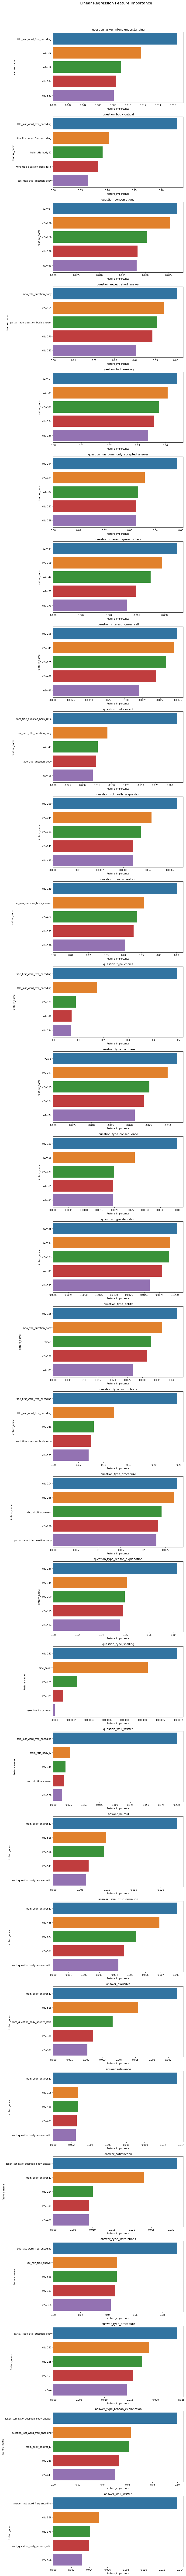

In [52]:
def plot_feature_importance(weights, feature_names, target_label, top, ax):
    map_importance = {
        name:abs(weights[index]) for index, name in enumerate(feature_names) 
    }
    feature_names, importances = \
    zip(*list(sorted(map_importance.items(), key = lambda x:x[1], reverse = True)[:top]))
    
    df = pd.DataFrame({
        'feature_name':feature_names,
        'feature_importance':importances
    })
    snb.barplot(x = 'feature_importance', y = 'feature_name', data = df, ax = ax)
    ax.set_title(target_label)
weights = lasso_reg.coef_
fig, axes = plt.subplots(30, 1, figsize = (10, 200))

for index, target in enumerate(target_cols): 
    plot_feature_importance(weights[index], feature_names, target, 5, axes[index])
fig.suptitle('Linear Regression Feature Importance', y = 0.889, fontsize = 16)

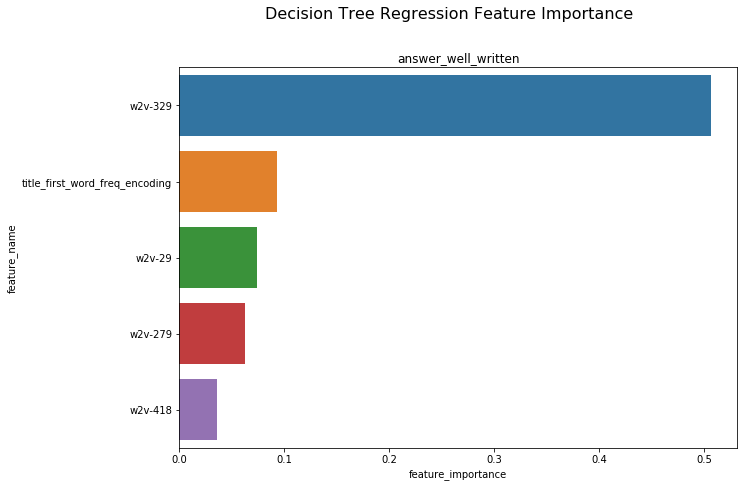

In [53]:
fig, axes = plt.subplots(1,1,figsize = (10, 7))
plot_feature_importance(decision_tree_reg.feature_importances_, feature_names, target, 5, axes)
fig.suptitle('Decision Tree Regression Feature Importance', y = 1, fontsize = 16)
plt.show()

#### Light GBM

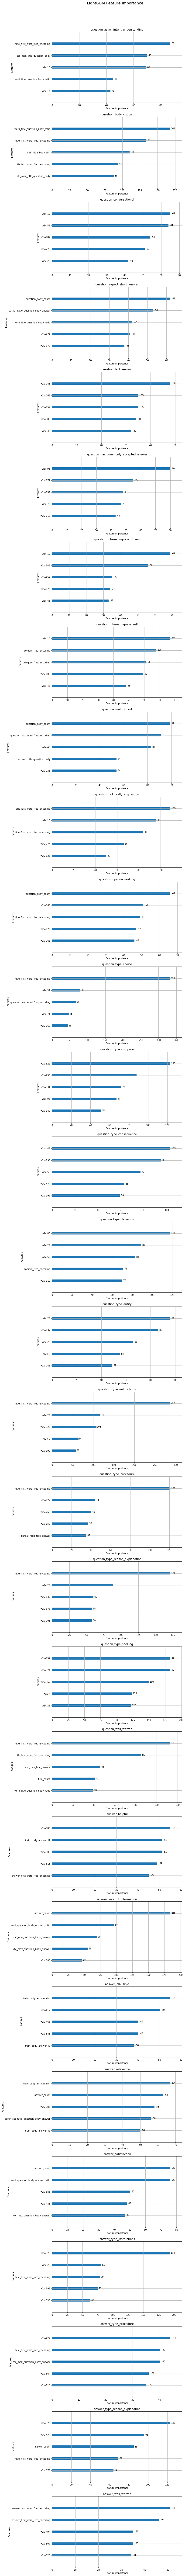

In [54]:
fig, axes = plt.subplots(30,1, figsize = (10, 200))
for i, col in enumerate(target_cols):
    plot_importance(lgb_reg[i].reg, ax = axes[i], max_num_features = 5, title = col)
    labels = list(axes[i].get_yticklabels())
    labels = [feature_names[int(each_label.get_text().split('_')[-1])] for each_label in labels]
    axes[i].set_yticklabels(labels)

fig.suptitle('LightGBM Feature Importance', y = 0.889, fontsize = 16)
plt.show()

In [ ]:
print(dump(lgb_reg, 'lgb_reg.joblib'))
print(dump(lasso_reg, 'lasso_reg.joblib'))
print(dump(svr_reg, 'svr_reg.joblib'))
print(dump(decision_tree_reg, 'dtree_reg.joblib'))

In [55]:
print("Best Parameters for Lasso Regressor")
print(lasso_reg.get_params())
print('\n')
print("Best Parameters for DecisionTree Regressor")
print(decision_tree_reg.get_params())
print('\n')
print("Best Parameters for Support Vector Regressor")
for i in range(30):
    print(f"--------------------------------- {target_cols[i]} -------------------------------------------")
    print(svr_reg[i].best_parameter)
print('\n')
print("Best Parameters for LightGBM Regressor")
for i in range(30):
    print(f"--------------------------------- {target_cols[i]} -------------------------------------------")
    print(lgb_reg[i].best_parameter)

Best Parameters for Lasso Regressor
{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


Best Parameters for DecisionTree Regressor
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


Best Parameters for Support Vector Regressor
--------------------------------- question_asker_intent_understanding -------------------------------------------
{'C': 0.1, 'max_iter': -1}
--------------------------------- question_body_critical -------------------------------------------
{'C': 100.0, 'max_iter': -1}
--------------------------------- question_conversational --------------------

In [56]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Fold", "CV Score"]
x.add_row(['Lasso', str(use_fold), str(validation_scores['lasso_reg'])])
x.add_row(['DecisionTree Regressor', str(use_fold), str(validation_scores['decision_tree_reg'])])
x.add_row(['Support Vector Regressor', str(use_fold), str(sum(validation_scores['svr'])/30)])
x.add_row(['LightGBM', str(use_fold), str(sum(validation_scores['lgb'])/30)])
print(x)

+--------------------------+------+---------------------+
|          Model           | Fold |       CV Score      |
+--------------------------+------+---------------------+
|          Lasso           |  2   |  0.3271249693004854 |
|  DecisionTree Regressor  |  2   | 0.23777686169273596 |
| Support Vector Regressor |  2   | 0.29759912961660095 |
|         LightGBM         |  2   |  0.3362847802400734 |
+--------------------------+------+---------------------+


### Submission Scores

In [57]:
from IPython.display import Image
Image(url= "img/ml.png")

## Conclusion
* LightGBM gives the best test score followed by SVR, DecisionTree Regressor, and Lasso Regressor
* Even though Lasso socres good in Cross Valdiation, it scores very low in the submission

In [61]:
print(os.environ['PATH'].split(';'))

['/Library/Frameworks/Python.framework/Versions/3.7/bin:/Users/varunsaproo/opt/miniconda3/condabin:/Library/Frameworks/Python.framework/Versions/3.7/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin']


## References
* Meta Features obtained from - https://www.kaggle.com/c/google-quest-challenge/discussion/130041